# Predicting School Grades

## Problem

We want to use <b>Scikit's Support Vector Regression (SVR)</b> to predict final school grades of high school students based on a number of features (school, demographics and social) of each student. 

## Given

This file <b>traindata.csv</b> contains the data of the students. The first row is the header. There are 549 students in the training set and each student is represented by 30 attributes. The last column contains the grade of the student which is to be predicted.

## To-Do

We are to apply SVR to this data and obtain a regression model to predict the grade based on the 30 parameters of each student. We can do model selection (type of kernel, kernel parameters, epsilon, C, etc.) through cross-validation on this data. We can either try to minimize the root mean square error or maximize the pearson or spearman correlation coefficients in our model selection.

## Testing

Once we have trained your model, our model will be tested on the test file: <b>testfeatures.csv</b>. The test file contains 100 test examples and has the same format as <b>train.csv</b> except that the last column (GRADES) is not present. We are to predict the GRADE of each example in the test file. 

# Solution

In [29]:
# importing the required modules

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cross_validation import train_test_split 
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler 
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Loading the dataset

In [3]:
# Loading train and test dataset

# reading the dataset using pandas
data_train = pd.read_csv("traindata.csv")
data_test = pd.read_csv("testfeatures.csv")

print "Train data dim.:", data_train.shape
print "Test data dim.:", data_test.shape

Train data dim.: (549, 31)
Test data dim.: (100, 30)


### Describing the dataset

In [4]:
# train dataset
# print top 5 entries 
data_train.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,GRADE
0,MS,F,17,R,GT3,T,4,2,other,other,...,yes,no,4,3,4,1,3,5,2,5
1,GP,M,17,R,LE3,T,1,3,other,other,...,no,yes,5,1,2,3,3,5,2,7
2,MS,M,21,R,LE3,T,1,1,at_home,other,...,yes,yes,5,3,3,5,2,4,21,9
3,MS,F,18,U,GT3,T,3,3,at_home,other,...,yes,no,4,1,4,1,1,3,8,5
4,MS,F,17,U,GT3,T,4,4,teacher,services,...,yes,yes,5,3,1,1,4,5,2,7


In [5]:
# describe the train data
data_train.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,GRADE
count,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000
mean,16.743169,2.508197,2.316940,1.573770,1.934426,0.227687,3.910747,3.167577,3.204007,1.510018,2.296903,3.510018,3.628415,7.098361
std,1.225331,1.126338,1.101469,0.762083,0.830134,0.598872,0.967187,1.060731,1.161385,0.937066,1.287648,1.445604,4.726497,3.186619
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,5.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,7.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,9.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000


In [6]:
# test dataset
# print top 5 entries
data_test.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,MS,F,18,U,LE3,T,4,3,health,services,...,yes,yes,no,3,2,4,1,4,1,8
1,MS,F,18,U,GT3,T,2,1,other,other,...,yes,yes,yes,4,3,1,1,1,5,10
2,MS,M,18,R,GT3,T,4,3,teacher,services,...,yes,yes,yes,5,3,2,1,2,4,4
3,MS,M,15,U,GT3,T,2,3,other,other,...,yes,yes,no,5,3,2,1,2,5,2
4,MS,M,15,U,LE3,T,2,2,services,services,...,yes,yes,no,5,3,3,1,3,4,2


In [7]:
# describe the test data
data_test.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences
count,100.000000,100.000000,100.000000,100.000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000
mean,16.750000,2.550000,2.250000,1.540,1.910000,0.19000,4.040000,3.250000,3.080000,1.460000,2.190000,3.68000,3.830000
std,1.183856,1.183856,1.095215,0.673,0.829932,0.56309,0.886715,0.998737,1.252714,0.857763,1.268858,1.44865,4.156181
min,15.000000,0.000000,1.000000,1.000,1.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000
25%,16.000000,2.000000,1.000000,1.000,1.000000,0.00000,4.000000,3.000000,2.000000,1.000000,1.000000,2.00000,0.000000
50%,17.000000,2.000000,2.000000,1.000,2.000000,0.00000,4.000000,3.000000,3.000000,1.000000,2.000000,4.00000,2.000000
75%,18.000000,4.000000,3.000000,2.000,2.000000,0.00000,5.000000,4.000000,4.000000,2.000000,3.000000,5.00000,6.250000
max,20.000000,4.000000,4.000000,3.000,4.000000,3.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,16.000000


## Pre-processing the Dataset

### Requirements for working with data in scikit-learn

1. Features and response are **separate objects**
2. Features and response should be **numeric**
3. Features and response should be **NumPy arrays**
4. Features and response should have **specific shapes**

### Pre-processing the Training Dataset

In [8]:
# handling Categorical variables with two categories
le = LabelEncoder()
data_train['school'] = le.fit_transform(data_train['school'].values)
data_train['sex'] = le.fit_transform(data_train['sex'].values)
data_train['address'] = le.fit_transform(data_train['address'].values)
data_train['famsize'] = le.fit_transform(data_train['famsize'].values)
data_train['Pstatus'] = le.fit_transform(data_train['Pstatus'].values)
data_train['schoolsup'] = le.fit_transform(data_train['schoolsup'].values)
data_train['famsup'] = le.fit_transform(data_train['famsup'].values)
data_train['paid'] = le.fit_transform(data_train['paid'].values)
data_train['activities'] = le.fit_transform(data_train['activities'].values)
data_train['nursery'] = le.fit_transform(data_train['nursery'].values)
data_train['higher'] = le.fit_transform(data_train['higher'].values)
data_train['internet'] = le.fit_transform(data_train['internet'].values)
data_train['romantic'] = le.fit_transform(data_train['romantic'].values)

In [9]:
# handling Categorical variables with more than two categories
dummies_train = pd.get_dummies(data_train[['Mjob', 'Fjob', 'reason', 'guardian']])
data_train = pd.concat([data_train, dummies_train], axis=1)

In [10]:
# train dataset
# print top 5 entries 
data_train.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,1,0,17,0,0,1,4,2,other,other,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,1,17,0,1,1,1,3,other,other,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,1,21,0,1,1,1,1,at_home,other,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,18,1,0,1,3,3,at_home,other,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,0,17,1,0,1,4,4,teacher,services,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
# After per-processing the training data by converting all categorical variables into numerical form
feature_cols_train = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
                'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup','paid', 'activities', 
                'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime',
                'goout', 'Dalc', 'Walc', 'health', 'absences',
                'Mjob_at_home', 'Mjob_other', 'Mjob_teacher', 'Mjob_health', 'Mjob_services',
                'Fjob_at_home', 'Fjob_other', 'Fjob_teacher', 'Fjob_health', 'Fjob_services',
                'reason_course', 'reason_home', 'reason_reputation', 'reason_other',           
                'guardian_father', 'guardian_mother', 'guardian_other'                
                ]

### Pre-processing the Testing Dataset

In [12]:
# handling Categorical variables with two categories
data_test['school'] = le.fit_transform(data_test['school'].values)
data_test['sex'] = le.fit_transform(data_test['sex'].values)
data_test['address'] = le.fit_transform(data_test['address'].values)
data_test['famsize'] = le.fit_transform(data_test['famsize'].values)
data_test['Pstatus'] = le.fit_transform(data_test['Pstatus'].values)
data_test['schoolsup'] = le.fit_transform(data_test['schoolsup'].values)
data_test['famsup'] = le.fit_transform(data_test['famsup'].values)
data_test['paid'] = le.fit_transform(data_test['paid'].values)
data_test['activities'] = le.fit_transform(data_test['activities'].values)
data_test['nursery'] = le.fit_transform(data_test['nursery'].values)
data_test['higher'] = le.fit_transform(data_test['higher'].values)
data_test['internet'] = le.fit_transform(data_test['internet'].values)
data_test['romantic'] = le.fit_transform(data_test['romantic'].values)

In [13]:
# handling Categorical variables with more than two categories
dummies_test = pd.get_dummies(data_test[['Mjob', 'Fjob', 'reason', 'guardian']])
data_test = pd.concat([data_test, dummies_test], axis=1)

In [14]:
# test dataset
# print top 5 entries
data_test.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,1,0,18,1,1,1,4,3,health,services,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,18,1,0,1,2,1,other,other,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1,1,18,0,0,1,4,3,teacher,services,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,1,15,1,0,1,2,3,other,other,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1,1,15,1,1,1,2,2,services,services,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [15]:
# After per-processing the testing data by converting all categorical variables into numerical form
feature_cols_test = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
                'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup','paid', 'activities', 
                'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime',
                'goout', 'Dalc', 'Walc', 'health', 'absences',
                'Mjob_at_home', 'Mjob_other', 'Mjob_teacher', 'Mjob_health', 'Mjob_services',
                'Fjob_at_home', 'Fjob_other', 'Fjob_teacher', 'Fjob_health', 'Fjob_services',
                'reason_course', 'reason_home', 'reason_reputation', 'reason_other',           
                'guardian_father', 'guardian_mother', 'guardian_other'                
                ]

## EDA (Exploratory Data Analysis)

### EDA on Training data

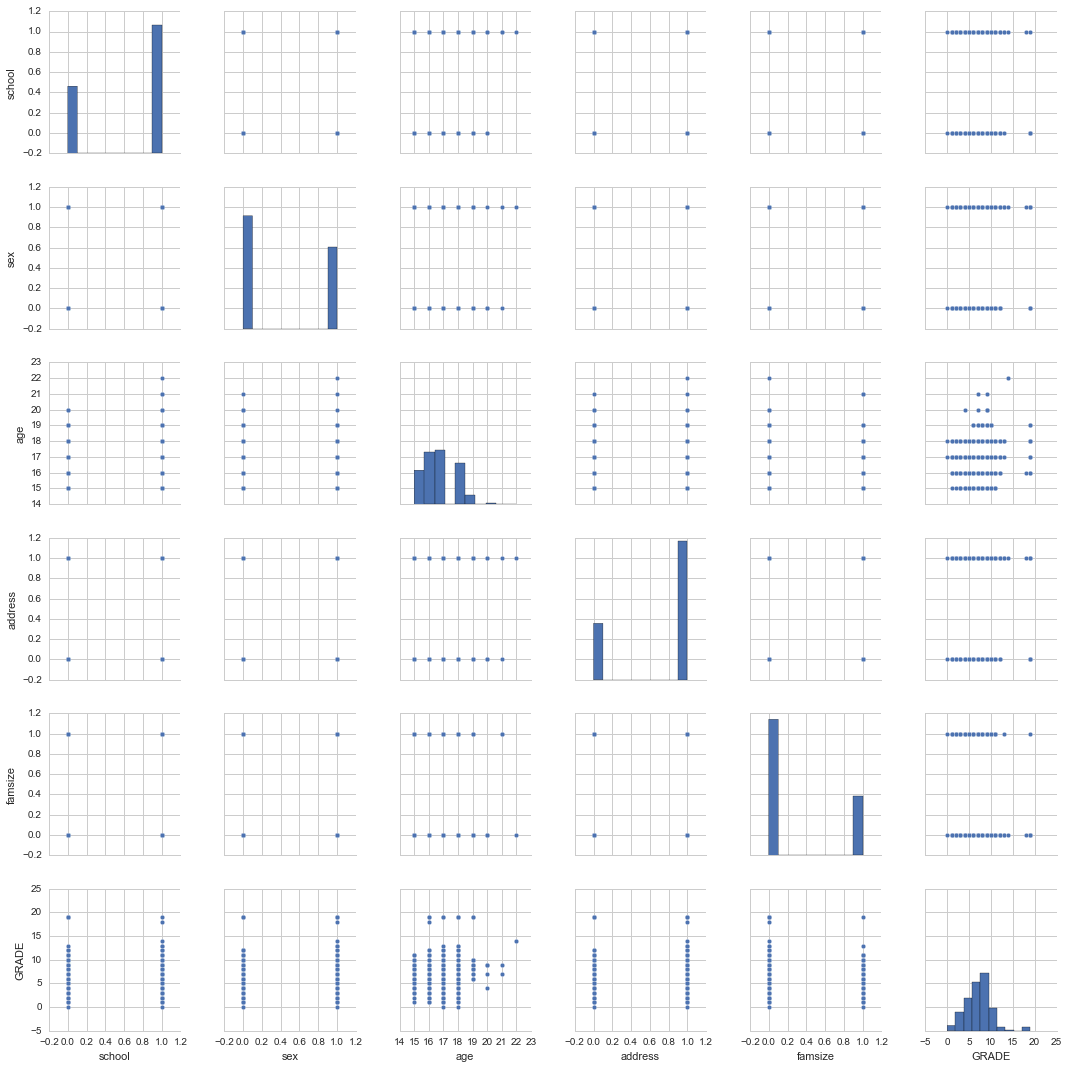

In [16]:
# visualizing the training dataset for Exploratory Data Analysis
sns.set(style='whitegrid', context='notebook')
cols = ['school', 'sex', 'age', 'address', 'famsize', 'GRADE']
sns.pairplot(data_train[cols], size=2.5)
plt.tight_layout()
#plt.savefig('data_train_eda.png', dpi=300)
plt.show()

In [18]:
cm_train_cc = np.corrcoef(data_train[feature_cols_train].values.T)
print "Train Corrcoef:", cm_train_cc

Train Corrcoef: [[ 1.          0.07396341 -0.10190395 ..., -0.0408837   0.02632089
   0.02158089]
 [ 0.07396341  1.         -0.05928903 ...,  0.0471316  -0.03451927
  -0.01710453]
 [-0.10190395 -0.05928903  1.         ..., -0.13264589 -0.06182133
   0.34409389]
 ..., 
 [-0.0408837   0.0471316  -0.13264589 ...,  1.         -0.84727967
  -0.14904297]
 [ 0.02632089 -0.03451927 -0.06182133 ..., -0.84727967  1.         -0.39893342]
 [ 0.02158089 -0.01710453  0.34409389 ..., -0.14904297 -0.39893342  1.        ]]


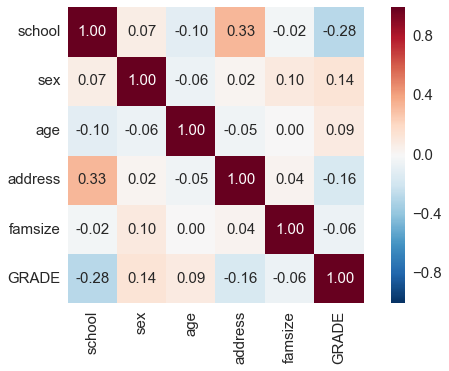

In [17]:
# plotting correlation matrix for training dataset
cols = ['school', 'sex', 'age', 'address', 'famsize', 'GRADE']
cm_train = np.corrcoef(data_train[cols].values.T)

sns.set(font_scale=1.5)
hm = sns.heatmap(cm_train, 
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=cols,
            xticklabels=cols)
            
plt.tight_layout()
plt.savefig('corr_mat_train.png', dpi=300)
plt.show()

### EDA on Testing data

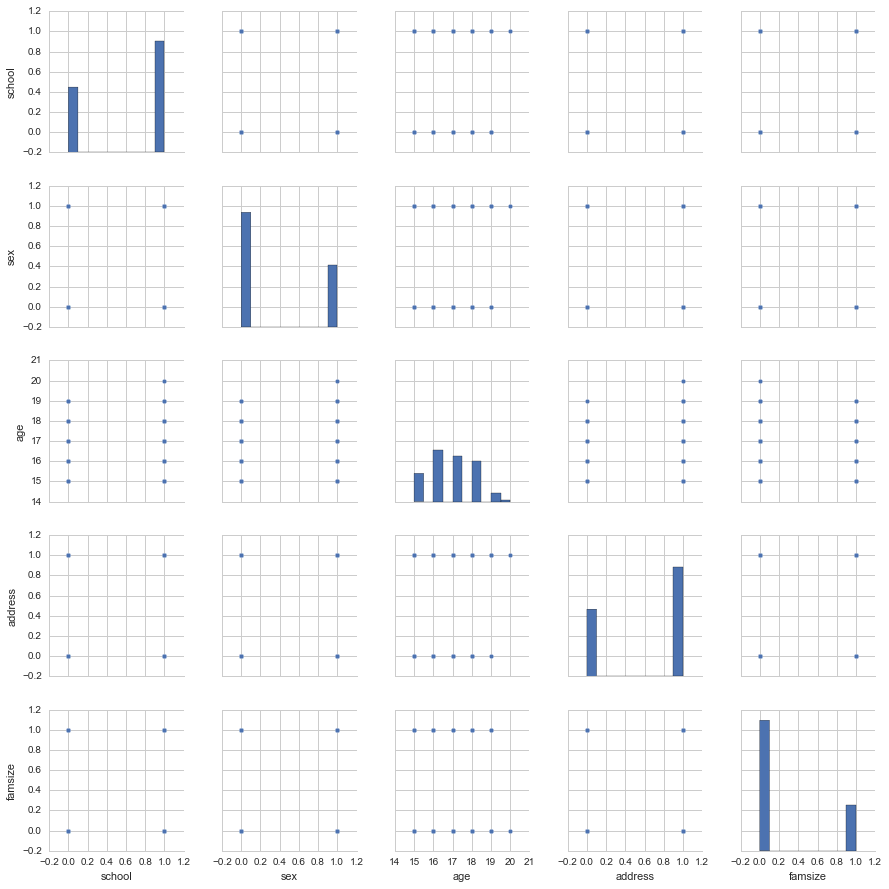

In [20]:
# visualizing the testing dataset for Exploratory Data Analysis
sns.set(style='whitegrid', context='notebook')
cols = ['school', 'sex', 'age', 'address', 'famsize']
sns.pairplot(data_test[cols], size=2.5)
plt.tight_layout()
#plt.savefig('data_test_eda.png', dpi=300)
plt.show()

In [22]:
cm_test_cc = np.corrcoef(data_test[feature_cols_test].values.T)
print "Test Corrcoef:", cm_test_cc

Test Corrcoef: [[ 1.          0.12810326 -0.00439595 ..., -0.21510279  0.20682377
  -0.0142552 ]
 [ 0.12810326  1.          0.04894693 ..., -0.01801582  0.00477977
   0.0240493 ]
 [-0.00439595  0.04894693  1.         ..., -0.16153328  0.02903168
   0.24345389]
 ..., 
 [-0.21510279 -0.01801582 -0.16153328 ...,  1.         -0.86981179
  -0.11828217]
 [ 0.20682377  0.00477977  0.02903168 ..., -0.86981179  1.         -0.38703691]
 [-0.0142552   0.0240493   0.24345389 ..., -0.11828217 -0.38703691  1.        ]]


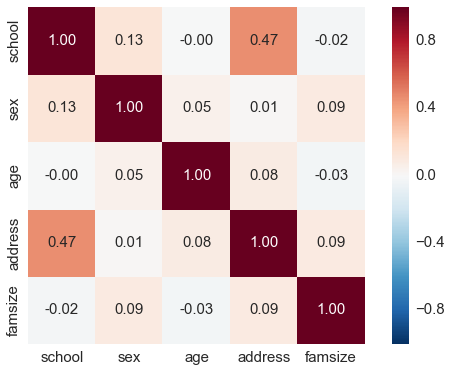

In [21]:
# plotting correlation matrix for testing dataset
cols = ['school', 'sex', 'age', 'address', 'famsize']
cm = np.corrcoef(data_test[cols].values.T)

sns.set(font_scale=1.5)
hm = sns.heatmap(cm, 
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=cols,
            xticklabels=cols)
            
plt.tight_layout()
plt.savefig('corr_mat_test.png', dpi=300)
plt.show()

## Model Training Phase

In [16]:
# create training data (Xtr) and its labels(ytr)
Xtr = data_train[feature_cols_train]
ytr = data_train.GRADE

In [17]:
# Spliting the train and test data
X_train, X_test, y_train, y_test = train_test_split(Xtr, ytr, test_size=0.30, random_state=101)

In [18]:
# standardize the data
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)
y_train_std = StandardScaler().fit_transform(y_train)
y_test_std = StandardScaler().fit_transform(y_test)

C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a

### Support Vector Regression

In [48]:
# Applying SVR(linear kernel) without standardization
regr_svr_lin = SVR(kernel='linear', C=0.1, epsilon=1)
regr_svr_lin.fit(X_train, y_train)
y_train_pred_svr_lin = regr_svr_lin.predict(X_train)
y_test_pred_svr_lin = regr_svr_lin.predict(X_test)
print "SVR linear coef:\n", regr_svr_lin.coef_

SVR linear coef:
[[-0.55922189  0.31322282 -0.16416114 -0.41566716 -0.33182527 -0.10614461
  -0.2353015  -0.14782637  0.14653788 -0.40395982  1.14553346  0.51454897
   0.03702275  0.14906628 -0.17167975  0.03429346 -0.64029615 -0.30552818
   0.28195694 -0.10398913  0.13723307  0.00889561  0.07589236  0.1548356
   0.07224718  0.04423748  0.21602133  0.00487339 -0.20810061 -0.0113004
  -0.00149371 -0.11780091 -0.05808037 -0.3         0.3         0.17588128
   0.34526893 -0.01422219 -0.4091967   0.07814997 -0.2894538   0.02705296
   0.26240084]]


In [49]:
# Applying SVR(linear kernel) with standardization
regr_svr_std_lin = SVR(kernel='linear', C=0.1, epsilon=1)
regr_svr_std_lin.fit(X_train_std, y_train_std)
y_train_pred_svr_std_lin = regr_svr_std_lin.predict(X_train_std)
y_test_pred_svr_std_lin = regr_svr_std_lin.predict(X_test_std)
print "SVR linear coef:\n", regr_svr_std_lin.coef_

SVR linear coef:
[[-0.1155387   0.09435691 -0.12059374  0.00745895 -0.07967277 -0.00495148
  -0.11115176  0.01090778 -0.02197269 -0.10248288  0.30695462  0.01005182
  -0.00790949  0.00938326 -0.02118698  0.13855243 -0.19737262 -0.03036575
   0.052982   -0.10013381  0.03377118  0.04890792 -0.03907245  0.14148056
   0.07736433 -0.0140774   0.0304793   0.03521362 -0.04532217 -0.01156898
  -0.03120461  0.01586876 -0.02186178 -0.01747398  0.05197092  0.00427409
   0.0340834  -0.03122758 -0.04227977  0.04151241 -0.05609517  0.02596677
   0.04736999]]


In [50]:
# Applying SVR(Polynomial kernel) without standardization
regr_svr_poly = SVR(kernel='poly', C=1, degree=1, epsilon=1)
regr_svr_poly.fit(X_train, y_train)
y_train_pred_svr_poly = regr_svr_poly.predict(X_train)
y_test_pred_svr_poly = regr_svr_poly.predict(X_test)

In [51]:
# Applying SVR(Polynomial kernel) with standardization
regr_svr_std_poly = SVR(kernel='poly', C=1, degree=1, epsilon=1)
regr_svr_std_poly.fit(X_train_std, y_train_std)
y_train_pred_svr_std_poly = regr_svr_std_poly.predict(X_train_std)
y_test_pred_svr_std_poly = regr_svr_std_poly.predict(X_test_std)

In [52]:
# Applying SVR(rbf kernel) without standardization
regr_svr_rbf = SVR(kernel='rbf', C=100, gamma=0.0001, epsilon=1)
regr_svr_rbf.fit(X_train, y_train)
y_train_pred_svr_rbf = regr_svr_rbf.predict(X_train)
y_test_pred_svr_rbf = regr_svr_rbf.predict(X_test)

In [53]:
# Applying SVR(rbf kernel) with standardization
regr_svr_std_rbf = SVR(kernel='rbf', C=100, gamma=0.0001, epsilon=1)
regr_svr_std_rbf.fit(X_train_std, y_train_std)
y_train_pred_svr_std_rbf = regr_svr_std_rbf.predict(X_train_std)
y_test_pred_svr_std_rbf = regr_svr_std_rbf.predict(X_test_std)

In [54]:
# Computing MAE, MSE and RMSE for Support Vector Regression without standardization
print "Without Standardization"
print('SVR(lin.): MAE train: %.3f, test: %.3f' % (mean_absolute_error(y_train, y_train_pred_svr_lin), 
                                                  mean_absolute_error(y_test, y_test_pred_svr_lin)))
print('SVR(lin.): MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred_svr_lin), 
                                                  mean_squared_error(y_test, y_test_pred_svr_lin)))
print('SVR(lin.): RMSE train: %.3f, test: %.3f' % (np.sqrt(mean_squared_error(y_train, y_train_pred_svr_lin)), 
                                                  np.sqrt(mean_squared_error(y_test, y_test_pred_svr_lin))))

print('SVR(poly): MAE train: %.3f, test: %.3f' % (mean_absolute_error(y_train, y_train_pred_svr_poly), 
                                                  mean_absolute_error(y_test, y_test_pred_svr_poly)))
print('SVR(poly): MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred_svr_poly), 
                                                  mean_squared_error(y_test, y_test_pred_svr_poly)))
print('SVR(poly): RMSE train: %.3f, test: %.3f' % (np.sqrt(mean_squared_error(y_train, y_train_pred_svr_poly)), 
                                                  np.sqrt(mean_squared_error(y_test, y_test_pred_svr_poly))))

print('SVR(rbf): MAE train: %.3f, test: %.3f' % (mean_absolute_error(y_train, y_train_pred_svr_rbf), 
                                                 mean_absolute_error(y_test, y_test_pred_svr_rbf)))
print('SVR(rbf): MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred_svr_rbf), 
                                                 mean_squared_error(y_test, y_test_pred_svr_rbf)))
print('SVR(rbf): RMSE train: %.3f, test: %.3f' % (np.sqrt(mean_squared_error(y_train, y_train_pred_svr_rbf)), 
                                                 np.sqrt(mean_squared_error(y_test, y_test_pred_svr_rbf))))

Without Standardization
SVR(lin.): MAE train: 1.790, test: 1.912
SVR(lin.): MSE train: 6.609, test: 6.540
SVR(lin.): RMSE train: 2.571, test: 2.557
SVR(poly): MAE train: 1.862, test: 2.007
SVR(poly): MSE train: 7.121, test: 7.079
SVR(poly): RMSE train: 2.669, test: 2.661
SVR(rbf): MAE train: 1.871, test: 2.017
SVR(rbf): MSE train: 7.205, test: 7.149
SVR(rbf): RMSE train: 2.684, test: 2.674


In [55]:
# Computing MAE, MSE and RMSE for Support Vector Regression with standardization
print "With Standardization"
print('SVR(lin.): MAE train: %.3f, test: %.3f' % (mean_absolute_error(y_train_std, y_train_pred_svr_std_lin), 
                                                  mean_absolute_error(y_test_std, y_test_pred_svr_std_lin)))
print('SVR(lin.): MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train_std, y_train_pred_svr_std_lin), 
                                                  mean_squared_error(y_test_std, y_test_pred_svr_std_lin)))
print('SVR(lin.): RMSE train: %.3f, test: %.3f' % (np.sqrt(mean_squared_error(y_train_std, y_train_pred_svr_std_lin)), 
                                                  np.sqrt(mean_squared_error(y_test_std, y_test_pred_svr_std_lin))))

print('SVR(poly): MAE train: %.3f, test: %.3f' % (mean_absolute_error(y_train_std, y_train_pred_svr_std_poly), 
                                                  mean_absolute_error(y_test_std, y_test_pred_svr_std_poly)))
print('SVR(poly): MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train_std, y_train_pred_svr_std_poly), 
                                                  mean_squared_error(y_test_std, y_test_pred_svr_std_poly)))
print('SVR(poly): RMSE train: %.3f, test: %.3f' % (np.sqrt(mean_squared_error(y_train_std, y_train_pred_svr_std_poly)), 
                                                  np.sqrt(mean_squared_error(y_test_std, y_test_pred_svr_std_poly))))

print('SVR(rbf): MAE train: %.3f, test: %.3f' % (mean_absolute_error(y_train_std, y_train_pred_svr_std_rbf), 
                                                 mean_absolute_error(y_test_std, y_test_pred_svr_std_rbf)))
print('SVR(rbf): MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train_std, y_train_pred_svr_std_rbf), 
                                                 mean_squared_error(y_test_std, y_test_pred_svr_std_rbf)))
print('SVR(rbf): RMSE train: %.3f, test: %.3f' % (np.sqrt(mean_squared_error(y_train_std, y_train_pred_svr_std_rbf)), 
                                                 np.sqrt(mean_squared_error(y_test_std, y_test_pred_svr_std_rbf))))

With Standardization
SVR(lin.): MAE train: 0.602, test: 0.612
SVR(lin.): MSE train: 0.669, test: 0.692
SVR(lin.): RMSE train: 0.818, test: 0.832
SVR(poly): MAE train: 0.597, test: 0.613
SVR(poly): MSE train: 0.665, test: 0.687
SVR(poly): RMSE train: 0.815, test: 0.829
SVR(rbf): MAE train: 0.597, test: 0.616
SVR(rbf): MSE train: 0.665, test: 0.689
SVR(rbf): RMSE train: 0.816, test: 0.830


In [56]:
# computing R^2 score
print "R^2 without standardization"
print('SVR(lin.): R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred_svr_lin), 
                                                  r2_score(y_test, y_test_pred_svr_lin)))
print('SVR(poly): R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred_svr_poly), 
                                                  r2_score(y_test, y_test_pred_svr_poly)))
print('SVR(rbf): R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred_svr_rbf), 
                                                 r2_score(y_test, y_test_pred_svr_rbf)))

R^2 without standardization
SVR(lin.): R^2 train: 0.350, test: 0.350
SVR(poly): R^2 train: 0.300, test: 0.296
SVR(rbf): R^2 train: 0.291, test: 0.289


In [57]:
print "R^2 with standardization"
print('SVR(lin.): R^2 train: %.3f, test: %.3f' % (r2_score(y_train_std, y_train_pred_svr_std_lin), 
                                                  r2_score(y_test_std, y_test_pred_svr_std_lin)))
print('SVR(poly): R^2 train: %.3f, test: %.3f' % (r2_score(y_train_std, y_train_pred_svr_std_poly), 
                                                  r2_score(y_test_std, y_test_pred_svr_std_poly)))
print('SVR(rbf): R^2 train: %.3f, test: %.3f' % (r2_score(y_train_std, y_train_pred_svr_std_rbf), 
                                                 r2_score(y_test_std, y_test_pred_svr_std_rbf)))

R^2 with standardization
SVR(lin.): R^2 train: 0.331, test: 0.308
SVR(poly): R^2 train: 0.335, test: 0.313
SVR(rbf): R^2 train: 0.335, test: 0.311


### Optimal Parameter Selection

In [44]:
# parameter selection for SVR lin.
pipe_svr = Pipeline([('scl', StandardScaler()), ('regr', SVR())])

param_range_cl = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_range_el = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

param_grid_l = {'regr__C': param_range_cl, 'regr__epsilon': param_range_el, 'regr__kernel': ['linear']}

gs_lin = GridSearchCV(estimator=pipe_svr, param_grid=param_grid_l, cv=10)
gs_lin = gs_lin.fit(X_train, y_train)
print gs_lin.best_score_
print gs_lin.best_params_

0.257488340382
{'regr__kernel': 'linear', 'regr__C': 0.1, 'regr__epsilon': 1.0}


In [45]:
# parameter selection for SVR poly
pipe_poly = Pipeline([('scl', StandardScaler()), ('regr', SVR())])

param_range_cp = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_range_ep = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_range_dp = [1.0, 2.0, 3.0, 4.0, 5.0]

param_grid_p = {'regr__C': param_range_cp, 'regr__epsilon': param_range_ep, 'regr__degree': param_range_dp, 
                'regr__kernel': ['poly']}

gs_poly = GridSearchCV(estimator=pipe_poly, param_grid=param_grid_p, cv=10)
gs_poly = gs_poly.fit(X_train, y_train)
print gs_poly.best_score_
print gs_poly.best_params_

0.269444759746
{'regr__kernel': 'poly', 'regr__C': 1.0, 'regr__epsilon': 1.0, 'regr__degree': 1.0}


In [47]:
# parameter selection for SVR rbf
pipe_rbf = Pipeline([('scl', StandardScaler()), ('regr', SVR())])

param_range_cr = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_range_er = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

param_grid_r = {'regr__C': param_range_cr, 'regr__epsilon': param_range_er, 'regr__gamma': param_range_cr, 
                'regr__kernel': ['rbf']}

gs_rbf = GridSearchCV(estimator=pipe_rbf, param_grid=param_grid_r, cv=10)
gs_rbf = gs_rbf.fit(X_train, y_train)
print gs_rbf.best_score_
print gs_rbf.best_params_

0.267780254685
{'regr__kernel': 'rbf', 'regr__C': 100.0, 'regr__epsilon': 1.0, 'regr__gamma': 0.0001}


### Features Selection

#### Embedded Methods

#### LASSO (Least Absolute Shrinkage & Selection Operator) (L1 norm)

In [35]:
# cross validation on lasso for optimal parameter selection
regr_lassocv = linear_model.LassoCV(cv=10)
regr_lassocv.fit(Xtr, ytr)

print "lasso alpha:", regr_lassocv.alpha_

lasso alpha: 0.0271941463282


In [38]:
# Applying Lasso without standardization
regr_lasso = linear_model.Lasso(alpha=.03)
regr_lasso.fit(X_train, y_train)
y_train_pred_svr_lasso = regr_lasso.predict(X_train)
y_test_pred_svr_lasso = regr_lasso.predict(X_test)
print "Lasso coef:", regr_lasso.coef_
print "Features coef:\n",zip(feature_cols_train, regr_lasso.coef_)

Lasso coef: [-0.99785189  0.36803816 -0.17435296 -0.34828821 -0.48421373 -0.
 -0.27567591 -0.09684807  0.00669336 -0.35987574  1.67002648  0.19963547
 -0.          0.         -0.01123966  0.19585269 -0.85923007 -0.21798367
  0.19334698 -0.13321867  0.06102527 -0.          0.14798596  0.20546508
  0.12421234  0.03415172  0.15126724  0.33742379 -0.         -0.         -0.
  0.         -0.06886521 -0.          0.          0.          0.03449641
 -0.         -0.33300163  0.17143369 -0.37982507  0.          0.        ]
Features coef:
[('school', -0.99785188723549856), ('sex', 0.3680381576490333), ('age', -0.17435295750961127), ('address', -0.34828820909248909), ('famsize', -0.48421372987329209), ('Pstatus', -0.0), ('Medu', -0.27567590995227909), ('Fedu', -0.096848068742021176), ('traveltime', 0.0066933637204970335), ('studytime', -0.35987573783428922), ('failures', 1.6700264765082811), ('schoolsup', 0.19963546817431074), ('famsup', -0.0), ('paid', 0.0), ('activities', -0.011239661052004999)

In [39]:
print('Lasso: MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred_svr_lasso),
                                              mean_squared_error(y_test, y_test_pred_svr_lasso)))
print('Lasso: R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred_svr_lasso),
                                              r2_score(y_test, y_test_pred_svr_lasso)))

Lasso: MSE train: 6.385, test: 6.598
Lasso: R^2 train: 0.372, test: 0.344


#### ElasticNet (L1 and L2 norm)

In [40]:
# cross validation on elasticnet for optimal parameter selection
regr_elasticcv = linear_model.ElasticNetCV(cv=10)
regr_elasticcv.fit(Xtr, ytr)

print "ElasticNet alpha:", regr_elasticcv.alpha_
print "ElasticNet l1 ratio:", regr_elasticcv.l1_ratio_

ElasticNet alpha: 0.0357838647711
ElasticNet l1 ratio: 0.5


In [42]:
# Applying ElasticNet without standardization
regr_elasticnet = linear_model.ElasticNet(alpha=.04, l1_ratio=.5)
regr_elasticnet.fit(X_train, y_train)
y_train_pred_svr_elasticnet = regr_elasticnet.predict(X_train)
y_test_pred_svr_elasticnet = regr_elasticnet.predict(X_test)
print "ElasticNet coef:", regr_elasticnet.coef_
print "Features coef:\n",zip(feature_cols_train, regr_elasticnet.coef_)

ElasticNet coef: [-0.91036961  0.39433918 -0.16092682 -0.36061843 -0.48867417 -0.
 -0.25976279 -0.11855944  0.02547729 -0.37773965  1.58156096  0.25324937
 -0.          0.05624368 -0.06927937  0.24156162 -0.79043031 -0.24828862
  0.22353854 -0.14694074  0.08402455 -0.002679    0.15396964  0.20675484
  0.12097175  0.03533606  0.18124506  0.34309189 -0.0908812  -0.
 -0.04765397  0.         -0.11973008 -0.          0.16071244  0.
  0.10189974 -0.02526517 -0.31552758  0.24093659 -0.40255303  0.          0.        ]
Features coef:
[('school', -0.91036961144271811), ('sex', 0.39433918226013165), ('age', -0.16092682042027423), ('address', -0.3606184279337199), ('famsize', -0.48867416711894635), ('Pstatus', -0.0), ('Medu', -0.25976278931519092), ('Fedu', -0.11855944304730781), ('traveltime', 0.025477291223001897), ('studytime', -0.37773965276216892), ('failures', 1.5815609641293404), ('schoolsup', 0.25324936905759438), ('famsup', -0.0), ('paid', 0.056243677707367455), ('activities', -0.0692793

In [43]:
print('ElasticNet: MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred_svr_elasticnet),
                                                   mean_squared_error(y_test, y_test_pred_svr_elasticnet)))
print('ElasticNet: R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred_svr_elasticnet), 
                                                   r2_score(y_test, y_test_pred_svr_elasticnet)))

ElasticNet: MSE train: 6.354, test: 6.583
ElasticNet: R^2 train: 0.375, test: 0.346


## Model Testing Phase

In [59]:
# create testing data (Xtt)
Xtt = data_test[feature_cols_test]

In [60]:
# Applying SVR(linear kernel) 
regr_svr_lin = SVR(kernel='linear', C=0.1, epsilon=1)
regr_svr_lin.fit(Xtr, ytr)
ytt_test_pred_svr_lin = regr_svr_lin.predict(Xtt)

output_svr = pd.DataFrame(ytt_test_pred_svr_lin)
output_svr.to_csv('output_svrlin.csv')

In [61]:
# Applying Lasso
regr_lasso = linear_model.Lasso(alpha=.03)
regr_lasso.fit(Xtr, ytr)
ytt_test_pred_lasso = regr_lasso.predict(Xtt)

output_lasso = pd.DataFrame(ytt_test_pred_lasso)
output_lasso.to_csv('output_lasso.csv')

In [62]:
# Applying ElasticNet 
regr_elasticnet = linear_model.ElasticNet(alpha=.04, l1_ratio=.5)
regr_elasticnet.fit(Xtr, ytr)
ytt_test_pred_elasticnet = regr_elasticnet.predict(Xtt)

output_elasticnet = pd.DataFrame(ytt_test_pred_lasso)
output_elasticnet.to_csv('output_elasticnet.csv')

## References

1- http://www.cs.colostate.edu/~asa/courses/cs646/spr12/pmwiki/pmwiki.php/Projects <br></br>
2- http://scikit-learn.org/stable/modules/linear_model.html <br></br>
3- http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing <br></br>
4- http://scikit-learn.org/stable/modules/feature_selection.html <br></br>
5- http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html<br></br>
6- http://scikit-learn.org/stable/modules/cross_validation.html <br></br>